# Advanced RAG: Context Enrichment Window

Vanilla RAG is great, but some situations need smaller chunks because larger ones can add unnecessary noise, like conversation history. Using couple-level chunks can work, but important context might be lost from previous or future replies. Bigger chunks could help, but they come with their own issues, like noise and limited chunk numbers. What's the Solution: **Context Enrichment**.

Let's see How it can be done.


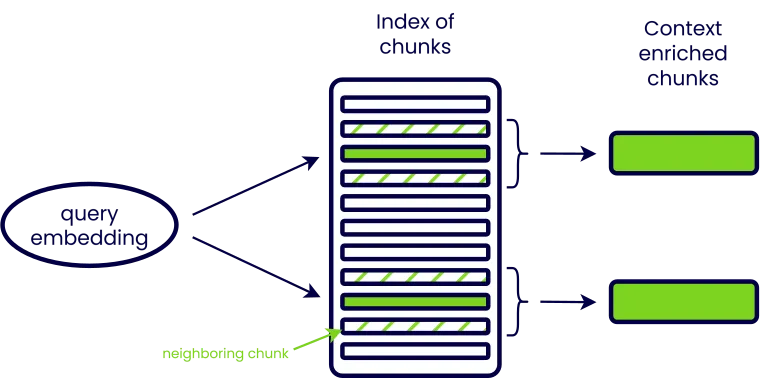

In [1]:
# install dependencies
! pip install -U openai lancedb einops sentence-transformers transformers datasets tantivy rerankers langchain PyMuPDF -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.7/383.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.0/30.0 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/7

## Download data

In [2]:
# Get a PDF for example
!mkdir ./data
!wget https://ncert.nic.in/ncerts/l/jess301.pdf -O ./data/history_chapter.pdf

--2024-10-16 10:04:05--  https://ncert.nic.in/ncerts/l/jess301.pdf
Resolving ncert.nic.in (ncert.nic.in)... 164.100.166.133
Connecting to ncert.nic.in (ncert.nic.in)|164.100.166.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 814721 (796K) [application/pdf]
Saving to: ‘./data/history_chapter.pdf’

./data/history_chap 100%[===================>] 795.63K   553KB/s    in 1.4s    

2024-10-16 10:04:07 (553 KB/s) - ‘./data/history_chapter.pdf’ saved [814721/814721]



## Table creation and data ingestion

In [3]:
# Import Libraries
import os, re, random, json
import pandas as pd
import torch
import lancedb
from lancedb.embeddings import get_registry
from lancedb.pydantic import LanceModel, Vector
from tqdm.auto import tqdm
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
import fitz
from typing import List

pd.set_option("max_colwidth", 750)  # For visibility

model = (
    get_registry()
    .get("sentence-transformers")
    .create(
        name="BAAI/bge-small-en-v1.5",
        device=("cuda" if torch.cuda.is_available() else "cpu"),
    )
)  # For embedding


def read_pdf_to_string(path):
    """
    Read a PDF document from the specified path and return its content as a string.

    Args:
        path (str): The file path to the PDF document.

    Returns:
        str: The concatenated text content of all pages in the PDF document.

    The function uses the 'fitz' library (PyMuPDF) to open the PDF document, iterate over each page,
    extract the text content from each page, and append it to a single string.
    """
    doc = fitz.open(path)  # Open the PDF document located at the specified path
    content = ""

    for page_num in range(len(doc)):  # Iterate over each page in the document
        page = doc[page_num]  # Get the current page
        content += (
            page.get_text()
        )  # Extract the text content from the current page and append it to the content string
    return content


def split_text_to_chunks_with_indices(
    text: str, chunk_size: int, chunk_overlap: int
) -> List[Document]:
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunk = text[start:end]
        chunks.append(
            Document(page_content=chunk, metadata={"index": len(chunks), "text": text})
        )
        start += chunk_size - chunk_overlap
    return chunks


content = read_pdf_to_string("/content/data/history_chapter.pdf")

CHUNK_SIZE = 512
CHUNK_OVERLAP = 128

text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
    length_function=len,
    is_separator_regex=False,
)

texts = text_splitter.create_documents([content])


# Create the table


class Schema(LanceModel):
    text: str = (
        model.SourceField()
    )  # the Columns (field) in DB whose Embedding we'll create
    chunk_index: int
    vector: Vector(model.ndims()) = model.VectorField()  # Default field


chunks = []
for index, doc in enumerate(texts):
    chunks.append({"text": doc.page_content, "chunk_index": index + 1})

MAX_CHUNK_INDEX = (
    index + 1
)  # we'll need this for our logic to get the final chunk index that exists in DB

db = lancedb.connect("./db")
table = db.create_table("documents", schema=Schema)

table.add(chunks)  # ingest docs with auto-vectorization
table.create_fts_index(
    "text"
)  # Create a fts index before so that we can use BM-25 later if we want to use Hybrid search

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

So we have created our table where each text chink has an index associated with it. Let's now do a simple search.

In [4]:
TOP_K = 3  # How many similar chunks to retrieve
NEIGHBOUR_WINDOW = 1  # 1 means 1 before and 1 after

QUERY = "What did the the revolution proclaim and what did the centralised administrative system do?"


initial_results = table.search(QUERY).limit(
    TOP_K
)  # Get all the similar chunks which are sorted by distance by default

initial_results.to_pandas().drop("vector", axis=1)

,text,chunk_index,_distance
0,"in 1789 under the rule of an absolute monarch.\nThe political and constitutional changes that came\nin the wake of the French Revolution led to the\ntransfer of sovereignty from the monarchy to a\nbody of French citizens. The revolution proclaimed\nthat it was the people who would henceforth\nconstitute the nation and shape its destiny.\nFrom the very beginning, the French revolutionaries\nintroduced various measures and practices that\ncould create a sense of collective identity amongst",14,0.589808
1,"3.3 1848: The Revolution of the Liberals\nParallel to the revolts of the poor, unemployed and starving peasants\nand workers in many European countries in the year 1848, a revolution\nled by the educated middle classes was under way. Events of February\n1848 in France had brought about the abdication of the monarch\nand a republic based on universal male suffrage had been proclaimed.\nIn other parts of Europe where independent nation-states did not\nyet exist – such as Germany, Italy, Poland, the Austro-Hungarian",86,0.627441
2,"body of active citizens and renamed the National Assembly. New\nhymns were composed, oaths taken and martyrs commemorated,\nall in the name of the nation. A centralised administrative system\nwas put in place and it formulated uniform laws for all citizens\nwithin its territory. Internal customs duties and dues were abolished\nand a uniform system of weights and measures was adopted.\nRegional dialects were discouraged and French, as it was spoken\nand written in Paris, became the common language of the nation.",16,0.638200


The important chunks from the query are 14, 86, and 16.

Using a ```NEIGHBOUR_WINDOW=1```, we get the following chunk IDs: 13, 14, 15; 85, 86, 87; and 15, 16, 17.

Notice ***chunk ID 15 appears in two groups***. It makes sense to associate it with the higher priority group (14), which has the minimum distance. Now, let's write the code to get the neighbors.

In [5]:
similar_chunk_indices = {}  # store previous and next neighbour chunk

for (
    i
) in (
    initial_results.to_list()
):  # Get all the similar chunks and their neighbour indices
    index = i["chunk_index"]
    similar_chunk_indices[index] = i["_distance"]

    for near in range(1, NEIGHBOUR_WINDOW + 1):
        if (max(0, index - near)) not in similar_chunk_indices:  # Previous neighbour
            similar_chunk_indices[(max(0, index - near))] = i[
                "_distance"
            ]  # This chunk will also have the same distance

        if (
            min(index + near, MAX_CHUNK_INDEX) not in similar_chunk_indices
        ):  # Next neighbour
            similar_chunk_indices[min(index + near, MAX_CHUNK_INDEX)] = i["_distance"]

similar_chunk_indices  # Look at the index 15. It is a part of 14 and 16 both

{14: 0.5898075699806213,
 13: 0.5898075699806213,
 15: 0.5898075699806213,
 86: 0.6274412870407104,
 85: 0.6274412870407104,
 87: 0.6274412870407104,
 16: 0.6381999850273132,
 17: 0.6381999850273132}

Now let's group and rerank these chunks

In [6]:
def group_and_rerank_chunks(indices_dict: dict):
    """
    function to take the {"chunk_index":"distance"} dict and return {"priority": indices_group_list} dict
    """

    sorted_indices = sorted(indices_dict.keys())  # Sort the indices

    # Group by distance with continuity consideration
    groups = []
    current_group = []
    current_min_distance = float("inf")

    for i in range(len(sorted_indices)):
        index = sorted_indices[i]
        distance = indices_dict[index]

        if not current_group:  # Start a new group
            current_group.append(index)
            current_min_distance = distance
        else:
            if index == current_group[-1] + 1:  # Check continuity
                current_group.append(index)
                current_min_distance = min(current_min_distance, distance)
            else:  # Save the current group and start a new one
                groups.append((current_min_distance, current_group))
                current_group = [index]
                current_min_distance = distance

    if current_group:  # add the last group
        groups.append((current_min_distance, current_group))

    groups.sort(key=lambda x: x[0])  # Sort groups by minimum distance

    return {i: group for i, (dist, group) in enumerate(groups)}


# group_and_rerank_chunks({
#         50:75, 51:75, 52:75, 53:75, 54:75, 55:75,
#         997:1, 998:1, 999:1,
#         5:50, 6:50, 7:50,
#         1:100, 2:100, 3:100,
#         8:100, 9:1000, 10:1000}) # Test this one to understand


reranked_indices = group_and_rerank_chunks(similar_chunk_indices)
reranked_indices  # Look at the group for 16. Even though it has more disatnce than 86 but since it's part of a continuous group, we put it before

{0: [13, 14, 15, 16, 17], 1: [85, 86, 87]}

In [7]:
indices_to_search = []
for priority, indices in reranked_indices.items():
    indices_to_search.extend(indices)

similar_results = (
    table.search()
    .where(f"chunk_index IN {tuple(indices_to_search)}")
    .limit(len(similar_chunk_indices))
    .to_pandas()
    .set_index("chunk_index")
    .loc[indices_to_search, :]
    .reset_index()
)  # Just a trick to sort the DF according to the chunk priority group


similar_results.drop("vector", axis=1)

,chunk_index,text
0,13,"understands them. Why, in his view, are nations\nimportant?\nDiscuss\nNew words\nPlebiscite – A direct vote by which all the\npeople of a region are asked to accept or reject\na proposal\n5\nNationalism in Europe\n1 The French Revolution and the Idea of the Nation\nThe first clear expression of nationalism came with\nthe French Revolution in 1789. France, as you\nwould remember, was a full-fledged territorial state\nin 1789 under the rule of an absolute monarch.\nThe political and constitutional changes that came"
1,14,"in 1789 under the rule of an absolute monarch.\nThe political and constitutional changes that came\nin the wake of the French Revolution led to the\ntransfer of sovereignty from the monarchy to a\nbody of French citizens. The revolution proclaimed\nthat it was the people who would henceforth\nconstitute the nation and shape its destiny.\nFrom the very beginning, the French revolutionaries\nintroduced various measures and practices that\ncould create a sense of collective identity amongst"
2,15,"introduced various measures and practices that\ncould create a sense of collective identity amongst\nthe French people. The ideas of la patrie (the\nfatherland) and le citoyen (the citizen) emphasised\nthe notion of a united community enjoying equal rights under a\nconstitution. A new French flag, the tricolour, was chosen to replace\nthe former royal standard. The Estates General was elected by the\nbody of active citizens and renamed the National Assembly. New"
3,16,"body of active citizens and renamed the National Assembly. New\nhymns were composed, oaths taken and martyrs commemorated,\nall in the name of the nation. A centralised administrative system\nwas put in place and it formulated uniform laws for all citizens\nwithin its territory. Internal customs duties and dues were abolished\nand a uniform system of weights and measures was adopted.\nRegional dialects were discouraged and French, as it was spoken\nand written in Paris, became the common language of the nation."
4,17,"Regional dialects were discouraged and French, as it was spoken\nand written in Paris, became the common language of the nation.\nThe revolutionaries further declared that it was the mission and the\ndestiny of the French nation to liberate the peoples of Europe\nfrom despotism, in other words to help other peoples of Europe\nto become nations.\nWhen the news of the events in France reached the different cities\nof Europe, students and other members of educated middle classes"
5,85,"person. He returned 24 hours later having requisitioned the army.\nIn the exchange that followed, eleven weavers were shot.\nFig. 9 — Peasants’ uprising, 1848.\nDescribe the cause of the Silesian weavers’\nuprising. Comment on the viewpoint of the\njournalist.\nDiscuss\nImagine you are a weaver who saw the events\nas they unfolded. Write a report on what you saw.\nActivity\n17\nNationalism in Europe\n3.3 1848: The Revolution of the Liberals\nParallel to the revolts of the poor, unemployed and starving peasants"
6,86,"3.3 1848: The Revolution of the Liberals\nParallel to the revolts of the poor, unemployed and starving peasants\nand workers in many European countries in the year 1848, a revolution\nled by the educated middle classes was under way. Events of February\n1848 in France had brought about the abdication of the monarch\nand a republic based on universal male suffrage had been proclaimed.\nIn other parts of Europe where independent nation-states did not\nyet exist – such as Germany, Italy, Poland, the Austro-Hungarian"
7,87,"yet exist – such as Germany, Italy, Poland, the Austro-Hungarian\nEmpire – men and women of the liberal middle classes combined\ntheir demands for constitutionalism with national unification. They\ntook advantage of the growing popular unrest to push their\ndemands for the creation of a nation-state on parliamentary\nprinciples – a constitution, freedom of the press and freedom\nof association.\nIn the German re

Now We simply go group by group and remove the overlapping prefix from the second entry onwards.

In [8]:
final_rag_text = "## Context - 1:\n"

group_priority = 0  # Priority of the Chunk group
grouped_indices = reranked_indices[group_priority]
remove_overlap = False  # from the 2nd element in the group, remove prefix overlap


for _, row in similar_results.iterrows():
    chunk_index = row["chunk_index"]

    if remove_overlap:  # if the previous chunk is there, remove the overlap
        final_rag_text += row["text"][CHUNK_OVERLAP:]
    else:
        final_rag_text += row["text"]

    remove_overlap = True

    if (
        chunk_index == grouped_indices[-1]
    ):  # last element of the group means the new group has started
        group_priority += 1
        remove_overlap = False  # new group has started so don't trim the first element

        if group_priority in reranked_indices:  # If not the last key in the dict
            final_rag_text += f"\n\n## Context - {group_priority+1}:\n"
            grouped_indices = reranked_indices[group_priority]


print(final_rag_text)

## Context - 1:
understands them. Why, in his view, are nations
important?
Discuss
New words
Plebiscite – A direct vote by which all the
people of a region are asked to accept or reject
a proposal
5
Nationalism   in   Europe
1  The French Revolution and the Idea of the Nation
The first clear expression of nationalism came with
the French Revolution in 1789. France, as you
would remember, was a full-fledged territorial state
in 1789 under the rule of an absolute monarch.
The political and constitutional changes that camelution led to the
transfer of sovereignty from the monarchy to a
body of French citizens. The revolution proclaimed
that it was the people who would henceforth
constitute the nation and shape its destiny.
From the very beginning, the French revolutionaries
introduced various measures and practices that
could create a sense of collective identity amongstof la patrie (the
fatherland) and le citoyen (the citizen) emphasised
the notion of a united community enjoying equal ri

## Voilla! We have enriched the context of chunks and utilized them in RAG